# Problema de Negocio (Enunciado de Kaggle)

### Descripción

Lucas ha decidido cambiar de aires y, por eso, ha comprado una tienda de portátiles. Sin embargo, su única especialidad es Data Science, por lo que ha decidido crear un modelo de ML para establecer los mejores precios.

¿Podrías ayudar a Lucas a mejorar ese modelo?

### Evaluación

Error de raíz cuadrada media (RMSE) es la desviación estándar de los valores residuales (errores de predicción). Los valores residuales son una medida de la distancia de los puntos de datos de la línea de regresión.

RMSE es una medida de cuál es el nivel de dispersión de estos valores residuales. En otras palabras, le indica el nivel de concentración de los datos en la línea de mejor ajuste.

$$RMSE = \sqrt{\frac{1}{n} \sum_{i=1}^{n} \left(\frac{d_i - f_i}{\sigma_i}\right)^2}$$

### Referencia

[Iván Cordero. (2024). Plan de negocio – DataTops®. Kaggle.](https://kaggle.com/competitions/datatops)


# Estrategia 2

Utilizar directamente CatBoost sobre las variables cateóricas parece que ha dado unos resultados mejorables.
En este NoteBook voy a hacer transformaciones de categóricas a numéricas para así poder usar otros algoritmos.

No habrá apenas comparación gráfica de las variables pues ya lo he hecho en "laptop_price_prediction_01_catboost".

# 0. Librerías

In [1]:
import os
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.metrics import mean_absolute_error, mean_squared_error, root_mean_squared_error
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, StandardScaler
from xgboost import XGBRegressor

from utils import datascience as ds
from utils import machinelearningtools as ml
from utils import vizdatatools as viz
from utils.functions import kaggle_checker

# Establecer un estilo moderno con Seaborn
sns.set_theme(style="darkgrid", palette='bright')


# 1. Entendiendo el problema de negocio

El principal objetivo del proyecto es crear un modelo de Machine Learning que permita a Lucas:

- Establecer precios precisos: Determinar el precio de venta ideal para cada portátil, considerando sus características técnicas.
- El rendimiento del modelo será evaluado utilizando el Error Cuadrático Medio (RMSE).
- Contamos con dos sets de trabajo:
    - `train.csv`: set de *train* sobre el que evaluaré las métricas y con el que entrenaré el modelo.
    - `test.csv`: set de *test* con el que predecir los precios de los portátiles, cuyo resultado (*submission*) se cargará a Kaggle.


# 2. Obtener datos y hacer las transformacines vistas en "laptop_price_prediction_01_catboost"

In [2]:
# Para que funcione necesitas bajarte los archivos de datos de Kaggle 
df_train = pd.read_csv(r'data/train.csv', index_col=0)

In [3]:
ds.get_cardinality(df_train, threshold_categorical=38, threshold_continuous=30.0)

pandas.DataFrame shape:  (912, 12)


,Card,%_Card,NaN_Values,%_NaN_Values,Type,Class
Company,19,2.083333,0,0.0,object,Categoric
Product,480,52.631579,0,0.0,object,Numeric - Continuous
TypeName,6,0.657895,0,0.0,object,Categoric
Inches,17,1.864035,0,0.0,float64,Categoric
ScreenResolution,36,3.947368,0,0.0,object,Categoric
Cpu,107,11.732456,0,0.0,object,Numeric - Discrete
Ram,9,0.986842,0,0.0,object,Categoric
Memory,37,4.057018,0,0.0,object,Categoric
Gpu,93,10.197368,0,0.0,object,Numeric - Discrete
OpSys,9,0.986842,0,0.0,object,Categoric


Conclusiones que se habían sacado del anterior análisis.

- Parece que están bastante bien escogidas todas las columna categóricas y no hay redundancias.

- Estoy bastante de acuerdo con la tabla anterior en la propuestas de clases (entre categóricas y numéricas). Voy a considerar como categóricas aqullas features que tengan una cardinalidad porcentual inferior al 5%. Además voy a intentar beneficiarme de que es un dataset compuesto de demasiadas columnas "object".

- Es bueno ver que no hay valores missing.

- Es un claro problema de regresión. El *target* es "Price_in_euros", aunque más adelante haremos una transformación sobre el target para que tenga una distribución normal.

# 3. Split de train y test

Hago esta separación desde el principio para no contaminar los datos

In [4]:
# Train-Test Split
train_set, test_set = train_test_split(df_train, test_size=0.2, random_state=42)

print(train_set.shape)
print(test_set.shape)

(729, 12)
(183, 12)


# 4. Mini-EDA y tranformaciones

Solo voy a transfor a numérica la columa de "Weight" porque todas las demás las voy a usar como categóricas.


In [5]:
# Transformar la columna "Weight" a numéricas, y convertir "Inches" en categórica
train_set['Inches'] = train_set['Inches'].astype(str)
train_set['WeightKg'] = train_set['Weight'].str.replace('kg', '').astype(float)
train_set.drop(['Weight'], axis=1, inplace=True)

# Convertir "Inches" en string para que lo interprete CatBoost
test_set['Inches'] = test_set['Inches'].astype(str)
test_set["WeightKg"] = test_set['Weight'].str.replace('kg', '').astype(float)
test_set.drop(['Weight'], axis=1, inplace=True)

Recordemos la distribución del *target* y hagamos algunas transformaciones.

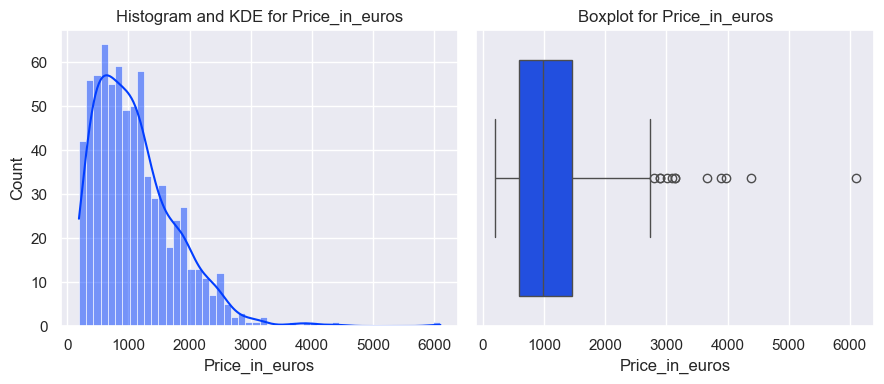

In [6]:
# Crear figura y subgráficas
fig, axs = plt.subplots(1, 2, figsize=(9, 4))

# Graficar el histograma con KDE en la primera subgráfica
sns.histplot(train_set['Price_in_euros'], kde=True, bins=50, ax=axs[0])
axs[0].set_title(f'Histogram and KDE for {'Price_in_euros'}')
axs[0].set_xlabel('Price_in_euros')

# Graficar el boxplot horizontal en la segunda subgráfica
sns.boxplot(x=train_set['Price_in_euros'], ax=axs[1], orient='h')
axs[1].set_title(f'Boxplot for {'Price_in_euros'}')
axs[1].set_xlabel('Price_in_euros')

# Ajustar el layout
plt.tight_layout()
plt.show()


Hay varios valores outliers por arriba, que si los dejo en el modelo puede que modifiquen la métrica que estoy buscando. Los voy a eliminar a riesgo de no aprender nada de los ordenadores más caros del set.

In [7]:
# Calcular los cuartiles y el IQR
Q1 = train_set['Price_in_euros'].quantile(0.25)
Q3 = train_set['Price_in_euros'].quantile(0.75)
IQR = Q3 - Q1

# Definir límite superior
upper_bound = Q3 + 1.5 * IQR
print('Precio límite de los outliers:', upper_bound, '€.')

Precio límite de los outliers: 2753.0 €.


Viendo el KDE no voy a ser tan estricto como eliminar los outliers que justo caigan en el "upper bound", si no que voy a darle un margen un poco por encima.

Con un filtro (upper_limit) en 3500 € tan solo voy a dejar fuera 5 muestras, de las 729.

Ojo porque este filtro solo lo voy a aplicar en el *train_set*, porque en el test me pueden venir ordenadores de cualquier precio.

In [8]:
# Filtro train_set eliminando lo valores de los outliers. 
upper_limit = 3500
train_set = train_set[~(train_set['Price_in_euros'] >= upper_limit)]
train_set.describe()

,Price_in_euros,WeightKg
count,724.000000,724.000000
mean,1081.008301,2.021374
std,612.069184,0.651501
min,191.900000,0.690000
25%,597.750000,1.497500
50%,979.000000,2.040000
75%,1434.000000,2.300000
max,3149.000000,4.600000


<Axes: xlabel='Price_in_euros', ylabel='Count'>

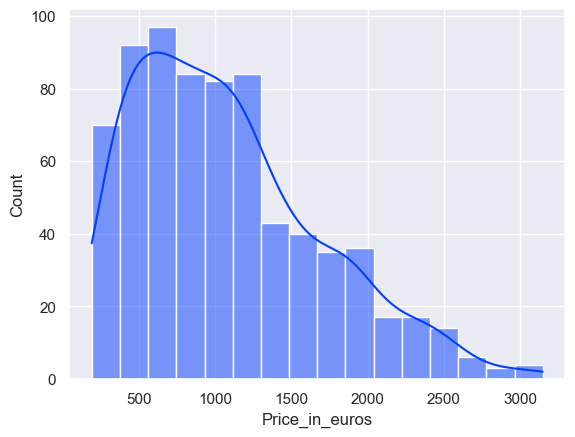

In [9]:
# Nueva densidad de probabilidad (tras eliminar outliers)
sns.histplot(train_set['Price_in_euros'], kde=True)

No tiene una mala distribución el target, pero seguro que se puede mejorar...

En esta ocasión sí que quiero aplicar una `tranformación logarítmica al target`, a ver si de esta forma mejoro los resultados de las estimaciones. Pero cuidado, porque después habrá que hacer la destransformación.

`Box-Cox` y `Yeo-Johnson` a través de Power Transform probablemente sean más convenientes, pero de momento los dejo fuera de mi análisis por tiempo. Además de momento voy a apostar por algoritmos de boosting en el que las distancias y distribución tienen menor importancia.

<Axes: xlabel='log_price_euros', ylabel='Count'>

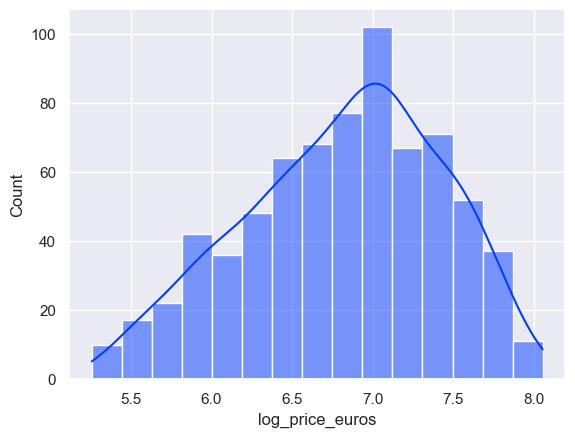

In [10]:
# Transformación logarítmica
train_set['log_price_euros'] = np.log(train_set['Price_in_euros'])
test_set['log_price_euros'] = np.log(test_set['Price_in_euros'])

sns.histplot(train_set['log_price_euros'], kde=True)

Conclusiones de esta matriz de correlaciones:

- Si trato "RamGB" como una numérica discreta, encuentro que tiene una alta correlación con "Price_in_euro", y puede que sea más conveniente que tratarla como una categórica.
- A su vez, si hago la anterior suposición, encuentro que "RamGB" y "WeightKg" tienen una alta colinealidad, lo que puede hacer que sea con dependedientes el resultado de la regresión mejore eliminando esta segunda.

Todas las conclusiones que he sacado hasta este punto van a servir para probar diferentes features, tratarlas de diferente forma y probar varios modelos de regresión.

La selección de varibles numéricas y categóricas va a ser la misma que en el NoteBook anterior, pero ahora el *target* es "log_price_euros"

In [11]:
target = 'Price_in_euros'
target_log = 'log_price_euros'
cat_features = ['Company', 'Product', 'TypeName', 'Inches', 'ScreenResolution', 'Cpu', 'Ram', 'Memory', 'Gpu', 'OpSys']
num_features = ['WeightKg']

# 5. Transformación de features


In [12]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
Index: 724 entries, 1118 to 418
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Company           724 non-null    object 
 1   Product           724 non-null    object 
 2   TypeName          724 non-null    object 
 3   Inches            724 non-null    object 
 4   ScreenResolution  724 non-null    object 
 5   Cpu               724 non-null    object 
 6   Ram               724 non-null    object 
 7   Memory            724 non-null    object 
 8   Gpu               724 non-null    object 
 9   OpSys             724 non-null    object 
 10  Price_in_euros    724 non-null    float64
 11  WeightKg          724 non-null    float64
 12  log_price_euros   724 non-null    float64
dtypes: float64(3), object(10)
memory usage: 79.2+ KB


In [13]:
X_train = train_set.drop(columns=[target, target_log])
y_train = train_set[target]
y_train_log = train_set[target_log]


X_test = test_set.drop(columns=[target, target_log])
y_test = test_set[target]
y_test_log = test_set[target_log]

Tengo demasiadas variables categóricas, y algunas de ellas con demasidas categorías como para hacer un One-Hot Encoder. Creo que favorecería la "maldición de la dimensionalidad.

Otras estrategias:
- Ordinal Encoder. Algunas variables categóricas sí parecen ser ordinales, pero ordenarlas a mano me va a llevar bastante tiempo.

- LabelEncoder. No se si esto es "legal" porque dice que solo se debería aplicar sobre el target, pero parace que me podría servir para codificar las features. De nuevo acepta cierta ordinalidad pero parece que sí la tengo con algunas variables. Aunque para esto ya uso el OrdinalEncoder.

- Target Encoding. Este método asigna un valor numérico a cada categoría en función del promedio del target para esa categoría. Puede ser útil para features de alta cardinalidad. Sin embargo, debe usarse con precaución para evitar el overfitting.

- Frecuency/Count Encoding. Este método reemplaza las categorías por la frecuencia de cada categoría. Es útil en casos donde hay muchas categorías y no se quiere aumentar el número de columnas como con One-Hot Encoding.

- Hashing Encoding. El Hashing Trick es otra opción para variables de alta cardinalidad. Se basa en aplicar una función hash a las categorías para reducirlas a un número fijo de columnas, lo que ayuda a controlar el tamaño de las características.

In [14]:
X_train_encoded = X_train.copy()
X_test_encoded = X_test.copy()

ord_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1) 

X_train_encoded[cat_features] = ord_encoder.fit_transform(X_train_encoded[cat_features])
X_test_encoded[cat_features] = ord_encoder.transform(X_test_encoded[cat_features])


In [15]:
X_train_encoded.head()

,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,WeightKg
laptop_ID,,,,,,,,,,,
1118,7.0,389.0,5.0,14.0,14.0,73.0,6.0,10.0,2.0,7.0,3.00
153,4.0,152.0,1.0,13.0,8.0,80.0,1.0,25.0,60.0,5.0,2.56
275,1.0,192.0,4.0,6.0,20.0,52.0,6.0,25.0,46.0,8.0,1.37
1100,7.0,66.0,3.0,9.0,8.0,54.0,4.0,22.0,37.0,7.0,1.54
131,4.0,155.0,3.0,14.0,8.0,84.0,1.0,18.0,6.0,5.0,2.80


In [16]:
X_test_encoded.head()

,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,WeightKg
laptop_ID,,,,,,,,,,,
451,7.0,-1.0,1.0,13.0,14.0,80.0,6.0,5.0,60.0,5.0,2.20
802,8.0,-1.0,0.0,13.0,7.0,60.0,6.0,15.0,25.0,5.0,2.08
723,8.0,-1.0,3.0,9.0,14.0,60.0,6.0,15.0,53.0,5.0,1.87
682,7.0,-1.0,0.0,9.0,13.0,46.0,4.0,4.0,58.0,5.0,1.63
1306,2.0,371.0,3.0,13.0,0.0,24.0,4.0,22.0,30.0,5.0,2.20


Estandarizado para los pesos de cada columna.

Aunque estando todo en el orden de las unidades, decenas o centenas no creo que esto sea tan determinante.

In [17]:
std_scaler = StandardScaler()
X_train_std = pd.DataFrame(std_scaler.fit_transform(X_train_encoded), columns=X_train_encoded.columns)
X_test_std = pd.DataFrame(std_scaler.transform(X_test_encoded), columns=X_test_encoded.columns)

In [18]:
X_train_std.describe()

,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,WeightKg
count,7.240000e+02,7.240000e+02,7.240000e+02,7.240000e+02,7.240000e+02,7.240000e+02,7.240000e+02,7.240000e+02,7.240000e+02,7.240000e+02,7.240000e+02
mean,-1.962825e-17,3.434944e-17,4.661710e-17,2.797026e-16,-4.907063e-17,-1.030483e-16,-3.434944e-17,1.275836e-16,-2.208178e-17,-1.570260e-16,4.318216e-16
std,1.000691e+00,1.000691e+00,1.000691e+00,1.000691e+00,1.000691e+00,1.000691e+00,1.000691e+00,1.000691e+00,1.000691e+00,1.000691e+00,1.000691e+00
min,-1.690405e+00,-1.757258e+00,-2.155917e+00,-3.235743e+00,-1.271630e+00,-3.011416e+00,-2.286320e+00,-2.264919e+00,-2.626763e+00,-4.635568e+00,-2.044962e+00
25%,-5.158818e-01,-7.580914e-01,-5.033135e-01,-5.502123e-01,-9.641282e-01,-4.568226e-01,-1.896820e-01,-7.230277e-01,-3.920617e-01,2.017788e-01,-8.046595e-01
50%,3.650107e-01,-9.198011e-02,3.229880e-01,6.433569e-01,-4.162315e-02,2.959802e-01,-1.896820e-01,4.791789e-02,-7.281865e-02,2.017788e-01,2.860865e-02
75%,6.586415e-01,8.480256e-01,3.229880e-01,6.433569e-01,7.271310e-01,7.402572e-01,8.586370e-01,8.188634e-01,7.784961e-01,2.017788e-01,4.279630e-01
max,3.007688e+00,1.783649e+00,1.975591e+00,9.417492e-01,3.648397e+00,1.480719e+00,8.586370e-01,2.514944e+00,2.237893e+00,3.104187e+00,3.960713e+00


In [19]:
X_test_std.describe()

,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,WeightKg
count,183.000000,183.000000,183.000000,183.000000,183.000000,183.000000,183.000000,183.000000,183.000000,183.000000,183.000000
mean,-0.101910,-0.674037,-0.015660,-0.087134,0.126411,-0.331187,0.088151,-0.017802,-0.145257,-0.110138,-0.033149
std,0.987453,1.209072,1.078866,1.111928,1.178529,1.303261,0.959279,1.069522,1.189906,1.298745,1.007511
min,-1.984036,-1.766023,-2.155917,-3.534135,-1.425381,-3.060780,-2.810480,-2.419108,-2.687571,-4.635568,-2.044962
25%,-0.956328,-1.766023,-1.329615,-0.550212,-0.887253,-0.888759,-0.189682,-0.723028,-0.741709,0.201779,-0.877618
50%,0.365011,-1.257675,0.322988,0.643357,-0.041623,-0.049569,0.858637,0.047918,-0.072819,0.201779,-0.032830
75%,0.658642,0.302428,0.322988,0.643357,0.880882,0.740257,0.858637,0.818863,0.900112,0.201779,0.435643
max,2.420426,1.739826,1.975591,0.941749,3.648397,1.431355,0.858637,2.206565,2.237893,3.104187,3.684237


# 6. Instanciación de modelos

In [20]:
# Instanciar modelos

lin_reg = LinearRegression()
en_reg = ElasticNet()

In [21]:
lin_reg.fit(X_train_std, y_train)
np.mean(-cross_val_score(lin_reg, X_train_std, y_train, scoring="neg_root_mean_squared_error", cv=5))


420.5573550684903

Para lograr que `ElasticNet` contemple las características de los modelos de Regresión Lineal, Ridge y Lasso a través de la búsqueda de hiperparámetros en GridSearchCV, voy a establecer un rango de valores de alpha y l1_ratio de tal manera que incluya los casos extremos que representen cada modelo:

- Regresión Lineal: alpha = 0 y l1_ratio = 0 (sin regularización).
- Ridge: alpha > 0 y l1_ratio = 0 (solo regularización L2).
- Lasso: alpha > 0 y l1_ratio = 1 (solo regularización L1).
- Elastic Net: cualquier combinación de alpha y l1_ratio entre 0 y 1.

In [22]:
y_train

laptop_ID
1118    2899.00
153     1249.26
275     1958.90
1100    1030.99
131     1396.00
         ...   
578      389.00
996      549.00
770     1859.00
407      306.00
418     1943.00
Name: Price_in_euros, Length: 724, dtype: float64

In [27]:
np.exp(y_train_log)

laptop_ID
1118    2899.00
153     1249.26
275     1958.90
1100    1030.99
131     1396.00
         ...   
578      389.00
996      549.00
770     1859.00
407      306.00
418     1943.00
Name: log_price_euros, Length: 724, dtype: float64

In [31]:
# ElasticNet

param_grid = {
    'alpha': [0, 0.01, 0.1, 1, 10, 100],
    'l1_ratio': [0, 0.5, 1], 
    'max_iter': [1000, 2000], 
    'tol': [1e-4, 1e-3] 
}

# Configurar el GridSearchCV
en_grid = GridSearchCV(estimator=en_reg, 
                       param_grid=param_grid,
                       scoring='neg_root_mean_squared_error',
                       cv=5,
                       verbose=1)

# Ajustar el modelo
en_grid.fit(X_train_std, y_train_log)

# Guardar modelos con "pickle"
os.makedirs('models', exist_ok=True)
with open('./models/en_grid_laptop_02.pkl', 'wb') as file:
    pickle.dump(en_grid, file)


Fitting 5 folds for each of 72 candidates, totalling 360 fits


c:\Users\Lander\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:1473: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
c:\Users\Lander\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
c:\Users\Lander\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.232e+01, tolerance: 2.145e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solver

Mejor modelo: ElasticNet(alpha=0.01, l1_ratio=0)
Mejores hiperparámetros: {'alpha': 0.01, 'l1_ratio': 0, 'max_iter': 1000, 'tol': 0.0001}
Mejor score: 0.39498639908834243
RMSE en el conjunto de train: 425.88461883133283
RMSE en el conjunto de test: 600.5521539927776


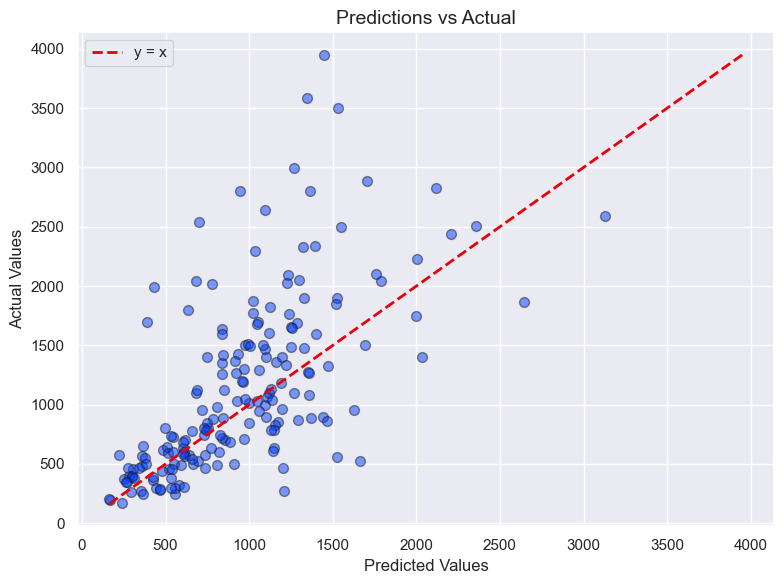

In [34]:
# CatBoost, GridSearchCV, stats

with open('./models/en_grid_laptop_02.pkl', 'rb') as file:
    estimator = pickle.load(file)

print(f"Mejor modelo: {estimator.best_estimator_}")
print(f"Mejores hiperparámetros: {estimator.best_params_}")
print(f"Mejor score: {-estimator.best_score_}")

# Predecir en el conjunto de train
y_pred = np.exp(estimator.best_estimator_.predict(X_train_std))
rmse = root_mean_squared_error(y_train, y_pred)
print(f"RMSE en el conjunto de train: {rmse}")

# Predecir en el conjunto de test
y_pred = np.exp(estimator.best_estimator_.predict(X_test_std))
rmse = root_mean_squared_error(y_test, y_pred)
print(f"RMSE en el conjunto de test: {rmse}")

ml.plot_predictions_vs_actual(y_test, y_pred)


Esto es muchísimo peor que lo que conseguí con CatBoost.

# 7. Predicción sobre set de Kaggle.

En este apartado cargamos el "test.csv" de Kaggle sobre el que se van a hacer las predicciones para competición. Hay que hacerle todas las transformaciones que se han hecho al conjunto de train.

In [25]:
print(gh)

NameError: name 'gh' is not defined

In [26]:
X_kaggle = pd.read_csv(r'data/test.csv', index_col=0)
# X_kaggle.index.name = None

In [27]:
# Transformar las columnas "Ram" y "Weight" a numéricas y eliminar las originales
X_kaggle['RamGB'] = X_kaggle['Ram'].str.replace('GB', '').astype(int)
X_kaggle["WeightKg"] = X_kaggle['Weight'].str.replace('kg', '').astype(float)
X_kaggle.drop(['Ram', 'Weight'], axis=1, inplace=True)
X_kaggle['Inches'] = X_kaggle['Inches'].astype(str)

In [28]:
X_kaggle.info()

<class 'pandas.core.frame.DataFrame'>
Index: 391 entries, 209 to 421
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Company           391 non-null    object 
 1   Product           391 non-null    object 
 2   TypeName          391 non-null    object 
 3   Inches            391 non-null    object 
 4   ScreenResolution  391 non-null    object 
 5   Cpu               391 non-null    object 
 6   Memory            391 non-null    object 
 7   Gpu               391 non-null    object 
 8   OpSys             391 non-null    object 
 9   RamGB             391 non-null    int32  
 10  WeightKg          391 non-null    float64
dtypes: float64(1), int32(1), object(9)
memory usage: 35.1+ KB


In [29]:
pred_cat_grid = cat_grid.best_estimator_.predict(X_kaggle)

In [30]:
submission_cat_grid_01 = pd.DataFrame({'laptop_ID': X_kaggle.index, 
                                       'Price_in_euros': pred_cat_grid})

In [31]:
submission_cat_grid_01.head()

,laptop_ID,Price_in_euros
0,209,1180.434754
1,1281,298.840542
2,1168,341.293131
3,1231,886.093704
4,1020,1059.253261


In [33]:
kaggle_checker(submission_cat_grid_01, 
               sample=pd.read_csv(r'./data/sample_submission.csv'),
               path=r'./submissions/submission_cat_grid_01.csv')

You're ready to submit!
